In [1]:
import pandas as pd
import json
import os
from pathlib import Path
from tqdm import tqdm
from numpy import genfromtxt
import re

# define paradigm classes

In [2]:
#source: https://github.com/awslabs/mlm-scoring/blob/master/examples/lingacc-blimp/accuracy.py

anaphor_agreement = {
    'anaphor_gender_agreement',
    'anaphor_number_agreement'
}

argument_structure = {
    'animate_subject_passive',
    'animate_subject_trans',
    'causative',
    'drop_argument',
    'inchoative',
    'intransitive',
    'passive_1',
    'passive_2',
    'transitive'
}

binding = {
    'principle_A_c_command',
    'principle_A_case_1',
    'principle_A_case_2',
    'principle_A_domain_1',
    'principle_A_domain_2',
    'principle_A_domain_3',
    'principle_A_reconstruction'
}

control_raising = {
    'existential_there_object_raising',
    'existential_there_subject_raising',
    'expletive_it_object_raising',
    'tough_vs_raising_1',
    'tough_vs_raising_2'
}

determiner_noun_agreement = {
    'determiner_noun_agreement_1',
    'determiner_noun_agreement_2',
    'determiner_noun_agreement_irregular_1',
    'determiner_noun_agreement_irregular_2',
    'determiner_noun_agreement_with_adjective_1',
    'determiner_noun_agreement_with_adj_2',
    'determiner_noun_agreement_with_adj_irregular_1',
    'determiner_noun_agreement_with_adj_irregular_2'
}

ellipsis = {
    'ellipsis_n_bar_1',
    'ellipsis_n_bar_2'
}

filler_gap = {
    'wh_questions_object_gap',
    'wh_questions_subject_gap',
    'wh_questions_subject_gap_long_distance',
    'wh_vs_that_no_gap',
    'wh_vs_that_no_gap_long_distance',
    'wh_vs_that_with_gap',
    'wh_vs_that_with_gap_long_distance'
}

irregular_forms = {
    'irregular_past_participle_adjectives',
    'irregular_past_participle_verbs'
}

island_effects = {
    'adjunct_island',
    'complex_NP_island',
    'coordinate_structure_constraint_complex_left_branch',
    'coordinate_structure_constraint_object_extraction',
    'left_branch_island_echo_question',
    'left_branch_island_simple_question',
    'sentential_subject_island',
    'wh_island'
}

npi_licensing = {
    'matrix_question_npi_licensor_present',
    'npi_present_1',
    'npi_present_2',
    'only_npi_licensor_present',
    'only_npi_scope',
    'sentential_negation_npi_licensor_present',
    'sentential_negation_npi_scope'
}

quantifiers = {
    'existential_there_quantifiers_1',
    'existential_there_quantifiers_2',
    'superlative_quantifiers_1',
    'superlative_quantifiers_2'
}

subject_verb_agreement = {
    'distractor_agreement_relational_noun',
    'distractor_agreement_relative_clause',
    'irregular_plural_subject_verb_agreement_1',
    'irregular_plural_subject_verb_agreement_2',
    'regular_plural_subject_verb_agreement_1',
    'regular_plural_subject_verb_agreement_2'
}


paradigms = [anaphor_agreement, argument_structure, binding, control_raising, determiner_noun_agreement,
            ellipsis, filler_gap, irregular_forms, island_effects, npi_licensing, quantifiers, subject_verb_agreement]
paradigm_names = ["anaphor_agreement", "argument_structure", "binding", "control_raising", "determiner_noun_agreement",
            "ellipsis", "filler_gap", "irregular_forms", "island_effects", "npi_licensing", "quantifiers", "subject_verb_agreement"]


In [3]:
paradigm_classes = []
for elm in paradigms:
    paradigm_classes.extend(list(elm))
paradigm_classes

['anaphor_number_agreement',
 'anaphor_gender_agreement',
 'passive_2',
 'intransitive',
 'animate_subject_trans',
 'drop_argument',
 'animate_subject_passive',
 'causative',
 'passive_1',
 'transitive',
 'inchoative',
 'principle_A_case_2',
 'principle_A_domain_2',
 'principle_A_domain_1',
 'principle_A_c_command',
 'principle_A_reconstruction',
 'principle_A_domain_3',
 'principle_A_case_1',
 'existential_there_object_raising',
 'existential_there_subject_raising',
 'tough_vs_raising_1',
 'expletive_it_object_raising',
 'tough_vs_raising_2',
 'determiner_noun_agreement_irregular_2',
 'determiner_noun_agreement_with_adj_2',
 'determiner_noun_agreement_with_adj_irregular_1',
 'determiner_noun_agreement_2',
 'determiner_noun_agreement_irregular_1',
 'determiner_noun_agreement_with_adj_irregular_2',
 'determiner_noun_agreement_1',
 'determiner_noun_agreement_with_adjective_1',
 'ellipsis_n_bar_2',
 'ellipsis_n_bar_1',
 'wh_questions_subject_gap',
 'wh_questions_subject_gap_long_distance'

# 1. Loop over results directory and gather all scores in a dictionary

In [4]:
models = [name for name in os.listdir(os.path.abspath("./results/BLiMP/"))]
paths = [os.path.join(os.path.abspath("./results/BLiMP/"),name) for name in os.listdir(os.path.abspath("./results/BLiMP/"))]

models_with_adjusted = []
for mod in models:
    if re.findall('bert', mod):
        models_with_adjusted.extend([f"{mod}_original", f"{mod}_adjusted_l2r", f"{mod}_adjusted_mlm",
                                     f"{mod}_adjusted_global_l2r"])
    else:
        continue #exlcude GPT models
        #models_with_adjusted.append(mod)
        
models_paths = list(zip(models, paths))
        
score_dict = {k: [] for k in models_with_adjusted}
score_dict

{'bert-base-cased_original': [],
 'bert-base-cased_adjusted_l2r': [],
 'bert-base-cased_adjusted_mlm': [],
 'bert-base-cased_adjusted_global_l2r': [],
 'bert-large-cased_original': [],
 'bert-large-cased_adjusted_l2r': [],
 'bert-large-cased_adjusted_mlm': [],
 'bert-large-cased_adjusted_global_l2r': [],
 'roberta-base_original': [],
 'roberta-base_adjusted_l2r': [],
 'roberta-base_adjusted_mlm': [],
 'roberta-base_adjusted_global_l2r': [],
 'roberta-large_original': [],
 'roberta-large_adjusted_l2r': [],
 'roberta-large_adjusted_mlm': [],
 'roberta-large_adjusted_global_l2r': []}

In [5]:
for (model, path) in models_paths:
    # print(model, path)
    for file in tqdm(Path(path).glob('*.txt')):
        with open(file, 'r') as f:
            array = f.readlines()[0]
            array = array.split(',')
            array = [elm.strip() for elm in array]
        if re.search('bert', model):
            if "AdjustedPLL_l2r" in str(file):
                key = f'{model}_adjusted_l2r'
            elif "AdjustedPLL_mlm" in str(file):
                key = f'{model}_adjusted_mlm'
            elif "AdjustedPLL_global_l2r" in str(file):
                key = f'{model}_adjusted_global_l2r'
            else:
                key = f'{model}_original'
            score_dict[key].append(array)
            
        else:
            key = model
        
        # score_dict[key].append(array) #exclude GPT models

    if not "gpt" in key:
        print(f"*****Nr. of scores computed for model {model}: {len(score_dict[key])}!*****")

score_dict

67it [00:00, 4388.58it/s]
265it [00:00, 4639.47it/s]


*****Nr. of scores computed for model bert-base-cased: 67!*****


201it [00:00, 5945.93it/s]


*****Nr. of scores computed for model bert-large-cased: 67!*****


67it [00:00, 5456.99it/s]
267it [00:00, 5747.10it/s]


*****Nr. of scores computed for model roberta-base: 66!*****


201it [00:00, 5141.96it/s]

*****Nr. of scores computed for model roberta-large: 67!*****


{'bert-base-cased_original': [['ellipsis_n_bar_1', '0.896'],
  ['causative', '0.804'],
  ['expletive_it_object_raising', '0.714'],
  ['animate_subject_trans', '0.755'],
  ['existential_there_object_raising', '0.767'],
  ['complex_NP_island', '0.56'],
  ['intransitive', '0.846'],
  ['sentential_negation_npi_scope', '0.788'],
  ['ellipsis_n_bar_2', '0.892'],
  ['wh_questions_subject_gap_long_distance', '0.738'],
  ['anaphor_gender_agreement', '0.988'],
  ['inchoative', '0.775'],
  ['coordinate_structure_constraint_object_extraction', '0.921'],
  ['determiner_noun_agreement_2', '1.0'],
  ['determiner_noun_agreement_1', '0.983'],
  ['determiner_noun_agreement_irregular_2', '0.994'],
  ['animate_subject_passive', '0.737'],
  ['determiner_noun_agreement_irregular_1', '0.916'],
  ['determiner_noun_agreement_with_adjective_1', '0.988'],
  ['irregular_past_participle_verbs', '0.936'],
  ['irregular_past_participle_adjectives', '0.994'],
  ['determiner_noun_agreement_with_adj_2', '0.976'],
  ['i

In [6]:
for k, v in score_dict.items():
    print(k, len(v))
    classes_computed = [elm[0] for elm in v]
    for elm in paradigm_classes:
        if elm not in classes_computed:
            print(f"Paradigm class *{elm}* missing!")
    print('\n')

bert-base-cased_original 64
Paradigm class *wh_vs_that_no_gap* missing!
Paradigm class *wh_vs_that_with_gap_long_distance* missing!
Paradigm class *existential_there_quantifiers_1* missing!


bert-base-cased_adjusted_l2r 67


bert-base-cased_adjusted_mlm 67


bert-base-cased_adjusted_global_l2r 67


bert-large-cased_original 67


bert-large-cased_adjusted_l2r 67


bert-large-cased_adjusted_mlm 67


bert-large-cased_adjusted_global_l2r 0
Paradigm class *anaphor_number_agreement* missing!
Paradigm class *anaphor_gender_agreement* missing!
Paradigm class *passive_2* missing!
Paradigm class *intransitive* missing!
Paradigm class *animate_subject_trans* missing!
Paradigm class *drop_argument* missing!
Paradigm class *animate_subject_passive* missing!
Paradigm class *causative* missing!
Paradigm class *passive_1* missing!
Paradigm class *transitive* missing!
Paradigm class *inchoative* missing!
Paradigm class *principle_A_case_2* missing!
Paradigm class *principle_A_domain_2* missing!
Paradi

In [7]:
# in the end assert that all models have all scores (67) calculated
# assert all(len(l) == 67 for l in score_dict.values())

# Aggregate scores by linguistic paradigm

In [8]:
paradigm_names

['anaphor_agreement',
 'argument_structure',
 'binding',
 'control_raising',
 'determiner_noun_agreement',
 'ellipsis',
 'filler_gap',
 'irregular_forms',
 'island_effects',
 'npi_licensing',
 'quantifiers',
 'subject_verb_agreement']

In [9]:
import numpy as np

paradigm_score_dict = {k: {} for k in models_with_adjusted}

for k, v in score_dict.items():
    # print(k)
    all_scores = []
    for ind, paradigm in enumerate(paradigms):
        # print(paradigm_names[ind])
        # print(paradigm)
        paradigm_scores = []
        for a in v:
            if a[0] in paradigm:
                # print(f"*{a[0]}* belongs to paradigm *{paradigm}*")
                paradigm_scores.append(a)
        paradigm_score = round(np.mean([float(x[1]) for x in paradigm_scores]) * 100, 1)
        # print(f"{paradigm_names[ind]} | {paradigm_score}\n")
        paradigm_score_dict[k][paradigm_names[ind]] = paradigm_score
        all_scores.extend([float(elm[1]) for elm in paradigm_scores])
    overall_score = round(np.mean(all_scores) * 100, 1)
    paradigm_score_dict[k]["overall"] = overall_score

/om2/user/ckauf/anaconda39/envs/minicons-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/om2/user/ckauf/anaconda39/envs/minicons-env/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
paradigm_score_dict

{'bert-base-cased_original': {'anaphor_agreement': 97.0,
  'argument_structure': 80.0,
  'binding': 82.3,
  'control_raising': 79.6,
  'determiner_noun_agreement': 97.6,
  'ellipsis': 89.4,
  'filler_gap': 85.0,
  'irregular_forms': 96.5,
  'island_effects': 73.6,
  'npi_licensing': 84.7,
  'quantifiers': 62.6,
  'subject_verb_agreement': 92.4,
  'overall': 84.2},
 'bert-base-cased_adjusted_l2r': {'anaphor_agreement': 97.1,
  'argument_structure': 81.0,
  'binding': 82.3,
  'control_raising': 81.9,
  'determiner_noun_agreement': 98.4,
  'ellipsis': 89.6,
  'filler_gap': 83.0,
  'irregular_forms': 96.5,
  'island_effects': 75.0,
  'npi_licensing': 85.0,
  'quantifiers': 69.8,
  'subject_verb_agreement': 92.1,
  'overall': 84.7},
 'bert-base-cased_adjusted_mlm': {'anaphor_agreement': 96.6,
  'argument_structure': 76.5,
  'binding': 81.5,
  'control_raising': 80.5,
  'determiner_noun_agreement': 96.9,
  'ellipsis': 87.1,
  'filler_gap': 82.5,
  'irregular_forms': 97.1,
  'island_effects':

# Save score dataframe

In [11]:
df = pd.DataFrame.from_dict(paradigm_score_dict).T

# Create a list of indices to use for sorting
index_order = ['bert-base-cased_original', 'bert-base-cased_adjusted_l2r', 'bert-base-cased_adjusted_mlm',
               'bert-base-cased_adjusted_global_l2r',
               'bert-large-cased_original', 'bert-large-cased_adjusted_l2r', 'bert-large-cased_adjusted_mlm',
               'bert-large-cased_adjusted_global_l2r',
               'roberta-base_original', 'roberta-base_adjusted_l2r', 'roberta-base_adjusted_mlm',
               'roberta-base_adjusted_global_l2r',
               'roberta-large_original', 'roberta-large_adjusted_l2r', 'roberta-large_adjusted_mlm',
               'roberta-large_adjusted_global_l2r',]

# Use reindex to sort the rows by the index order
df_sorted = df.reindex(index_order)

# reorder (put Overall first)
cols = list(df_sorted.columns)
cols = [cols[-1]] + cols[:-1]
df_sorted = df_sorted[cols]

#rename columns
rename_dict = {
    "anaphor_agreement" : "ANA. AGR",
    "argument_structure" : "ARG STR.",
    "binding" : "BINDING",
    "control_raising" : "CTRL. RAIS.",
    "determiner_noun_agreement" : "D-N AGR",
    "ellipsis" : "ELLIPSIS",
    "filler_gap" : "FILLER GAP",
    "irregular_forms" : "IRREGULAR",
    "island_effects" : "ISLAND",
    "npi_licensing" : "NPI",
    "quantifiers" : "QUANTIFIERS",
    "subject_verb_agreement": "S-V AGR",
    "overall" : "Overall"
}

df_renamed = df_sorted.rename(columns=rename_dict)

#rename rows
raname_rows_dict = {
    'bert-base-cased_original' : 'BERT (base) | PLL-original',
    'bert-base-cased_adjusted_l2r' : 'BERT (base) | PLL-word-l2r',
    'bert-base-cased_adjusted_mlm' : 'BERT (base) | PLL-whole-word',
    'bert-base-cased_adjusted_global_l2r' : 'BERT (base) | PLL-global-l2r',
    #
    'bert-large-cased_original' : 'BERT (large) | PLL-original',
    'bert-large-cased_adjusted_l2r' : 'BERT (large) | PLL-word-l2r',
    'bert-large-cased_adjusted_mlm' : 'BERT (large) | PLL-whole-word',
    'bert-large-cased_adjusted_global_l2r' : 'BERT (large) | PLL-global-l2r',
    #
    'roberta-base_original' : 'RoBERTa (base) | PLL-original',
    'roberta-base_adjusted_l2r' : 'RoBERTa (base) | PLL-word-l2r',
    'roberta-base_adjusted_mlm' : 'RoBERTa (base) | PLL-whole-word',
    'roberta-base_adjusted_global_l2r' : 'RoBERTa (base) | PLL-global-l2r',
    #
    'roberta-large_original' : 'RoBERTa (large) | PLL-original',
    'roberta-large_adjusted_l2r' : 'RoBERTa (large) | PLL-word-l2r',
    'roberta-large_adjusted_mlm' : 'RoBERTa (large) | PLL-whole-word',
    'roberta-large_adjusted_global_l2r' : 'RoBERTa (large) | PLL-global-l2r'
}

df_renamed = df_renamed.rename(index=raname_rows_dict)

df_renamed.to_csv('blimp_scores_aggregated.csv')
df_renamed

,Overall,ANA. AGR,ARG STR.,BINDING,CTRL. RAIS.,D-N AGR,ELLIPSIS,FILLER GAP,IRREGULAR,ISLAND,NPI,QUANTIFIERS,S-V AGR
BERT (base) | PLL-original,84.2,97.0,80.0,82.3,79.6,97.6,89.4,85.0,96.5,73.6,84.7,62.6,92.4
BERT (base) | PLL-word-l2r,84.7,97.1,81.0,82.3,81.9,98.4,89.6,83.0,96.5,75.0,85.0,69.8,92.1
BERT (base) | PLL-whole-word,83.1,96.6,76.5,81.5,80.5,96.9,87.1,82.5,97.1,74.9,83.8,69.2,88.5
BERT (base) | PLL-global-l2r,58.7,80.3,63.0,68.3,53.5,82.1,68.3,47.8,47.3,56.5,38.9,51.6,50.7
BERT (large) | PLL-original,84.8,97.2,80.7,82.0,82.7,97.6,86.4,84.3,92.8,77.0,83.4,72.8,91.9
BERT (large) | PLL-word-l2r,85.0,96.8,80.6,81.9,84.8,97.8,85.8,84.0,92.0,78.8,83.6,71.7,91.2
BERT (large) | PLL-whole-word,82.6,96.6,75.7,79.9,81.4,95.2,83.6,83.3,90.1,78.7,81.5,70.4,86.7
BERT (large) | PLL-global-l2r,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RoBERTa (base) | PLL-original,85.4,97.3,83.5,77.8,81.9,97.0,91.4,90.1,96.2,80.7,81.0,69.8,91.9
RoBERTa (base) | PLL-word-l2r,86.7,97.8,84.8,78.7,84.9,98.3,91.6,90.0,95.4,81.0,84.4,69.7,94.0


In [12]:
# print to LaTeX and adjust from there
print(df_renamed.to_latex())

/tmp/ipykernel_3621747/2711608311.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_renamed.to_latex())


\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
{} &  Overall &  ANA. AGR &  ARG STR. &  BINDING &  CTRL. RAIS. &  D-N AGR &  ELLIPSIS &  FILLER GAP &  IRREGULAR &  ISLAND &   NPI &  QUANTIFIERS &  S-V AGR \\
\midrule
BERT (base) | PLL-original       &     84.2 &      97.0 &      80.0 &     82.3 &         79.6 &     97.6 &      89.4 &        85.0 &       96.5 &    73.6 &  84.7 &         62.6 &     92.4 \\
BERT (base) | PLL-word-l2r       &     84.7 &      97.1 &      81.0 &     82.3 &         81.9 &     98.4 &      89.6 &        83.0 &       96.5 &    75.0 &  85.0 &         69.8 &     92.1 \\
BERT (base) | PLL-whole-word     &     83.1 &      96.6 &      76.5 &     81.5 &         80.5 &     96.9 &      87.1 &        82.5 &       97.1 &    74.9 &  83.8 &         69.2 &     88.5 \\
BERT (base) | PLL-global-l2r     &     58.7 &      80.3 &      63.0 &     68.3 &         53.5 &     82.1 &      68.3 &        47.8 &       47.3 &    56.5 &  38.9 &         51.6 &     50.7 \\
BERT (large) | PLL-origin

`Note Salazar et al. (2020) report GPT-2 scores for the 345M parameter model. That is gpt2-medium!`

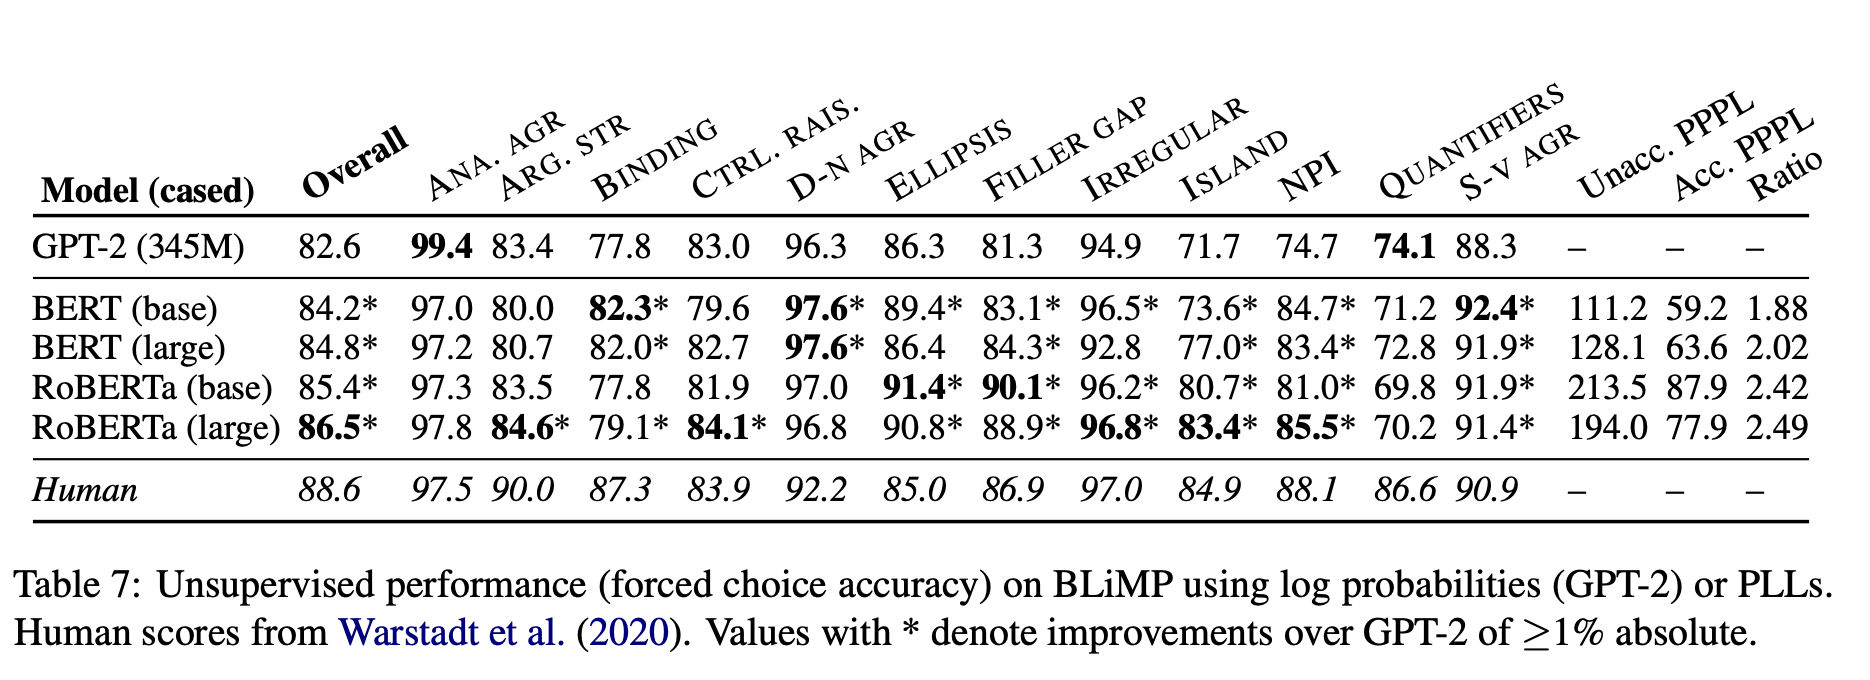

In [13]:
from IPython.display import Image
Image("Salazar_scores.png")